In [468]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

In [469]:
# Definir el tamaño del dataset
data_size = 5000

# Crear un DataFrame con características y valores nulos
df = pd.DataFrame({
    'feature1': np.random.randn(data_size),
    'feature2': np.random.randn(data_size),
    'feature3': np.random.randn(data_size),
    'feature4': np.random.randn(data_size),
    'feature5': np.random.choice(['manzana', 'pera', 'uva'], size=data_size),
    'feature6': np.random.choice(['rojo', 'verde', 'azul'], size=data_size),
    'target': np.random.choice([0, 1], size=data_size)
})

# Introducir valores nulos en características numéricas y categóricas
nan_indices_num = np.random.choice(data_size, size=1000, replace=False)
df.loc[nan_indices_num[:500], 'feature1'] = np.nan
df.loc[nan_indices_num[500:], 'feature2'] = np.nan

nan_indices_cat = np.random.choice(data_size, size=500, replace=False)
df.loc[nan_indices_cat[:250], 'feature5'] = np.nan
df.loc[nan_indices_cat[250:], 'feature6'] = np.nan

# Mostrar el dataset con valores nulos
print("Dataset con valores nulos:")
print(df.head(10))

Dataset con valores nulos:
   feature1  feature2  feature3  feature4 feature5 feature6  target
0 -1.325486 -0.116328 -0.869145  0.029418      NaN     rojo       1
1 -1.583923 -0.015549 -0.158960  0.852234     pera     rojo       0
2 -0.384768  0.805913 -1.812284 -1.260822  manzana     azul       1
3 -0.800042  0.219123  0.339966 -0.041381  manzana     azul       1
4  1.235942 -1.338197 -0.744320 -0.593922     pera     azul       1
5 -1.686996       NaN -1.220437  1.079755      uva     azul       0
6  1.002519 -0.116878  0.482856  0.371263      uva     rojo       0
7 -1.045345 -0.873769  1.192498 -0.986072  manzana     azul       0
8  0.385143 -1.002330  0.195491  2.034929     pera     rojo       1
9  1.081388 -0.619088  2.406916  0.721159      uva     azul       0


# 1. Explocar los datos y analizarlos

In [470]:
df2 = df.copy()
print('Número de observaciones (filas) = {}'.format(df2.shape[0]))
print('Total de variables disponibles (columnas) = {} '.format(df2.columns.shape[0]))
print('Columnas que cuentan con un valor nulo -')
print(df2.isnull().sum())

Número de observaciones (filas) = 5000
Total de variables disponibles (columnas) = 7 
Columnas que cuentan con un valor nulo -
feature1    500
feature2    500
feature3      0
feature4      0
feature5    250
feature6    250
target        0
dtype: int64


In [471]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  4500 non-null   float64
 1   feature2  4500 non-null   float64
 2   feature3  5000 non-null   float64
 3   feature4  5000 non-null   float64
 4   feature5  4750 non-null   object 
 5   feature6  4750 non-null   object 
 6   target    5000 non-null   int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 254.0+ KB


*0 < |𝑟| < 0.3: Correlación débil. La relación entre las variables es débil.*

*𝑟 = -0.1: Una correlación negativa débil.*

*En esta matriz de correlación, quiere decir que cada columna es independiente entre si*

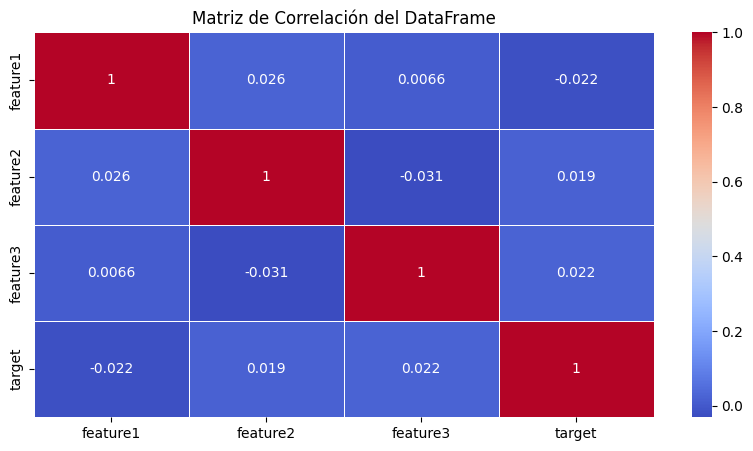

In [472]:
corr_matrix = df2[['feature1','feature2','feature3','target']].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación del DataFrame')
plt.show()


# Cambiar valores categoricos

In [473]:
diccionario = {'manzana': 1, 'pera': 2, 'uva': 3, 'rojo': 1, 'verde': 2, 'azul': 3}

df2['feature5'] = df2['feature5'].map(diccionario)
df2['feature6'] = df2['feature6'].map(diccionario)

In [474]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  4500 non-null   float64
 1   feature2  4500 non-null   float64
 2   feature3  5000 non-null   float64
 3   feature4  5000 non-null   float64
 4   feature5  4750 non-null   float64
 5   feature6  4750 non-null   float64
 6   target    5000 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 254.0 KB


In [475]:
df2.isnull().sum()

feature1    500
feature2    500
feature3      0
feature4      0
feature5    250
feature6    250
target        0
dtype: int64

# K vecinos más cercanos

In [476]:
# Imputar valores nulos en características binarias usando KNN
knn_imputer = KNNImputer(n_neighbors=2)
df2[['feature1','feature2','feature3','feature4','feature5','feature6']] = knn_imputer.fit_transform(df2[['feature1','feature2','feature3','feature4','feature5','feature6']]).round()
print(df2)

      feature1  feature2  feature3  feature4  feature5  feature6  target
0         -1.0      -0.0      -1.0       0.0       2.0       1.0       1
1         -2.0      -0.0      -0.0       1.0       2.0       1.0       0
2         -0.0       1.0      -2.0      -1.0       1.0       3.0       1
3         -1.0       0.0       0.0      -0.0       1.0       3.0       1
4          1.0      -1.0      -1.0      -1.0       2.0       3.0       1
...        ...       ...       ...       ...       ...       ...     ...
4995      -0.0      -3.0       1.0      -0.0       3.0       3.0       0
4996      -0.0      -2.0       1.0       0.0       1.0       1.0       0
4997       1.0      -1.0      -1.0       0.0       2.0       1.0       0
4998       1.0       1.0      -1.0       2.0       1.0       1.0       1
4999       0.0      -2.0       0.0       1.0       3.0       1.0       1

[5000 rows x 7 columns]


# 

In [477]:
df2.isnull().sum()

feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
target      0
dtype: int64

In [478]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  5000 non-null   float64
 1   feature2  5000 non-null   float64
 2   feature3  5000 non-null   float64
 3   feature4  5000 non-null   float64
 4   feature5  5000 non-null   float64
 5   feature6  5000 non-null   float64
 6   target    5000 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 254.0 KB


# OneHotEncoder

In [479]:
# One-Hot Encoding para características categóricas
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_encoded = ohe.fit_transform(df2[['feature5','feature6']])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=ohe.get_feature_names_out(['feature5','feature6']))

# Combinar con el DataFrame original sin la columna categórica original
df_combined = pd.concat([df2.drop(columns=['feature5','feature6']), cat_encoded_df], axis=1)
df2 = df_combined

In [480]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   feature1      5000 non-null   float64
 1   feature2      5000 non-null   float64
 2   feature3      5000 non-null   float64
 3   feature4      5000 non-null   float64
 4   target        5000 non-null   int32  
 5   feature5_1.0  5000 non-null   float64
 6   feature5_2.0  5000 non-null   float64
 7   feature5_3.0  5000 non-null   float64
 8   feature6_1.0  5000 non-null   float64
 9   feature6_2.0  5000 non-null   float64
 10  feature6_3.0  5000 non-null   float64
dtypes: float64(10), int32(1)
memory usage: 410.3 KB


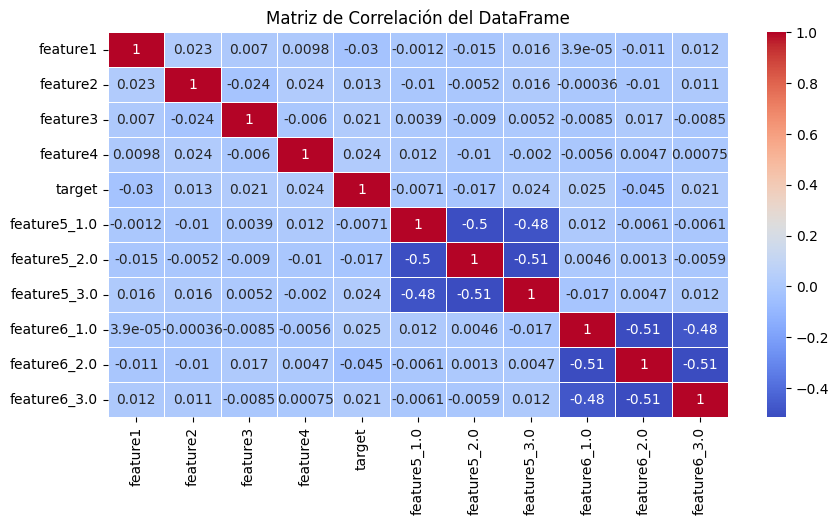

In [481]:
corr_matrix = df2[['feature1','feature2','feature3','feature4','target','feature5_1.0','feature5_2.0','feature5_3.0','feature6_1.0','feature6_2.0','feature6_3.0']].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación del DataFrame')
plt.show()

In [482]:
df2.describe()

,feature1,feature2,feature3,feature4,target,feature5_1.0,feature5_2.0,feature5_3.0,feature6_1.0,feature6_2.0,feature6_3.0
count,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,-0.005600,-0.01240,-0.00280,-0.030400,0.506400,0.323600,0.347200,0.32920,0.324800,0.354000,0.321200
std,1.024587,1.01649,1.03296,1.042925,0.500009,0.467896,0.476128,0.46997,0.468347,0.478257,0.466984
min,-4.000000,-4.00000,-4.00000,-4.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,-1.000000,-1.00000,-1.00000,-1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
max,3.000000,3.00000,4.00000,5.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


# 2. Entrenar el modelo

In [483]:
from sklearn.model_selection import train_test_split
X = df2.drop(columns=['target'])
y = df2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Estandalizar o normalizar los datos

In [484]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Regresión logistica

In [485]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# 5. Evaluar el modelo

In [486]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluación para Regresión Logística
print("Regresión Logística:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))

Regresión Logística:
Accuracy: 0.537
Confusion Matrix:
 [[212 292]
 [171 325]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.42      0.48       504
           1       0.53      0.66      0.58       496

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.53      1000
weighted avg       0.54      0.54      0.53      1000



# 6. Validación Cruzada
*Usa validación cruzada para obtener una estimación robusta del rendimiento del modelo.*


In [487]:
scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Cross-Validation Scores: [0.52375 0.52875 0.5375  0.5425  0.4925 ]
Mean: 0.5250000000000001
Standard Deviation: 0.01751784804135485


# 7. Optimización de Hiperparámetros

In [488]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' es compatible con 'l1' y 'l2'
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Best Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Estimator: LogisticRegression(C=1, penalty='l1', solver='liblinear')


# 8. Guardar el modelo

In [499]:
joblib.dump(grid_search.best_estimator_,'modelo_frank_v1.pkl') # Joblib sirve para guardar el modelo

['modelo_frank_v1.pkl']

# 9. Cargar el Modelo y Hacer Predicciones

In [500]:
best_log_reg_model = joblib.load('modelo_frank_v1.pkl')
predictions = best_log_reg_model.predict(X_test_scaled)
print("Predictions:", predictions)

Predictions: [0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1
 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0
 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0
 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1
 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1
 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1
 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 1 1
 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0
 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1
 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1
 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0
 1 1 0 0 1 1

In [498]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Regresión Logística:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))


Regresión Logística:
Accuracy: 0.537
Confusion Matrix:
 [[212 292]
 [171 325]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.42      0.48       504
           1       0.53      0.66      0.58       496

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.53      1000
weighted avg       0.54      0.54      0.53      1000

